#  Project – E-commerce User Behavior Segmentation

### Objective
Segment customers based on their purchase behavior using:
- **K-Means**
- **Hierarchical Clustering**
- **DBSCAN**

### Dataset
- **Online Retail Dataset (2010–2011)** from UCI/Kaggle
- Contains ~500K transactions of a UK-based online retail company
- Features: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country

### Business Goal
- Identify **VIPs, Regular buyers, Discount hunters, Dormant customers**
- Provide **targeted marketing strategies** for each cluster


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail/Online_Retail.csv


1.Import Libraries

Description:
We import Python libraries for data processing, visualization, and clustering. Each library has a purpose:

pandas/numpy → Data handling

matplotlib/seaborn → Charts

scikit-learn → Scaling & clustering

scipy → Dendrogram for hierarchical clustering

plotly → Interactive visuals

In [2]:
# What this cell does:
# Imports all required libraries for data analysis, visualization, and clustering.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")


In [3]:
# Load the Online Retail dataset (Kaggle version)
data = pd.read_csv("/kaggle/input/online-retail/Online_Retail.csv", encoding='ISO-8859-1')

# Display first 5 rows
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


Load Dataset

Description:
We load the Online Retail dataset (CSV from Kaggle). The dataset contains raw transaction records.

In [4]:
# What this cell does:
# Shows basic dataset info and missing values.

print("Dataset shape:", data.shape)
print("\nMissing values:\n", data.isnull().sum())
data.describe()


Dataset shape: (541909, 8)

Missing values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# Remove missing CustomerID (anonymous users)
data = data.dropna(subset=['CustomerID'])

# Remove negative or zero quantities
data = data[data['Quantity'] > 0]

# Remove negative or zero prices
data = data[data['UnitPrice'] > 0]

# Create TotalAmount = Quantity * UnitPrice
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

print("After cleaning:", data.shape)


After cleaning: (397884, 9)


Data Cleaning

Description:

Remove missing CustomerIDs (anonymous users)

Remove negative/zero values in Quantity and UnitPrice

Create TotalAmount = Quantity × UnitPrice
This ensures data is clean for analysis.

In [6]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Reference date = last invoice date
reference_date = data['InvoiceDate'].max()

# RFM table
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                     # Frequency
    'TotalAmount': 'sum'                                      # Monetary
})

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalAmount': 'Monetary'}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


Feature Engineering (RFM)

Description:
We build RFM features for each customer:

Recency: Days since last purchase

Frequency: Number of purchases

Monetary: Total money spent
This is the foundation for clustering.

In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled[:5]


array([[ 2.33457414, -0.3965777 ,  8.35866818],
       [-0.90534032,  0.39464896,  0.25096626],
       [-0.17535959, -0.26543516, -0.02859601],
       [-0.73534481, -0.08183561, -0.0330118 ],
       [ 2.17457836, -0.32663501, -0.19134727]])

Scale Features

Description:
Scaling ensures fair comparison since Recency, Frequency, and Monetary are in different units.

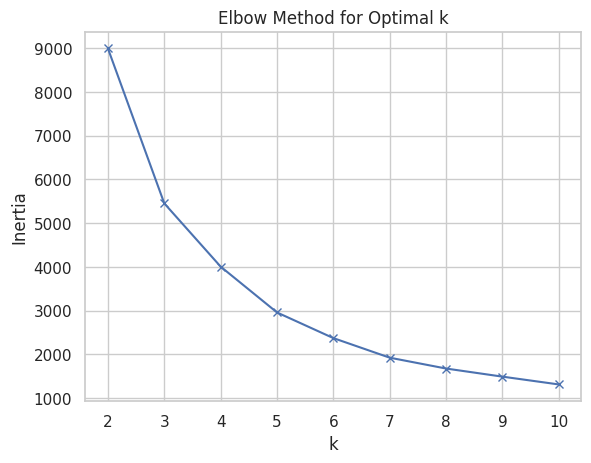

KMeansCluster
0    3247
1    1081
2       6
3       4
Name: count, dtype: int64

In [8]:
# Elbow method
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Fit KMeans with chosen K (say 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeansCluster'] = kmeans.fit_predict(rfm_scaled)

# Check distribution
rfm['KMeansCluster'].value_counts()


K-Means Clustering

Description:

Use Elbow method to find optimal clusters

Apply K-Means with chosen k (usually 4)

Assign each customer to a cluster

In [17]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)
rfm['pca1'], rfm['pca2'] = pca_data[:,0], pca_data[:,1]

fig = px.scatter(rfm, x='pca1', y='pca2', color='KMeansCluster',
                 title="K-Means Customer Segments",
                 hover_data=['Recency','Frequency','Monetary'])
fig.show()


K-Means Visualization

Description:
Use PCA to reduce dimensions and plot customers in 2D scatter by cluster. This makes results easy to understand.

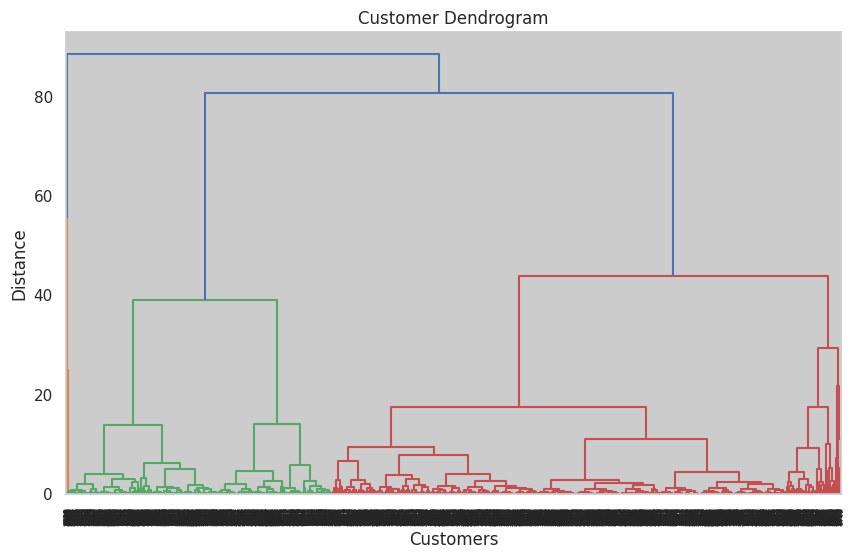

HierCluster
0    2843
2    1484
1       7
3       4
Name: count, dtype: int64

In [10]:
# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method='ward'))
plt.title("Customer Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

# Fit Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
rfm['HierCluster'] = hc.fit_predict(rfm_scaled)

rfm['HierCluster'].value_counts()


Hierarchical Clustering

Description:

Plot Dendrogram to visualize merging of clusters

Apply Agglomerative Clustering with Ward linkage

In [11]:
# Fit DBSCAN
db = DBSCAN(eps=1.8, min_samples=5)
rfm['DBSCANCluster'] = db.fit_predict(rfm_scaled)

rfm['DBSCANCluster'].value_counts()


DBSCANCluster
 0    4320
-1      18
Name: count, dtype: int64

DBSCAN

Description:
Use DBSCAN to detect dense clusters and outliers (noise customers). Good for irregular-shaped clusters.

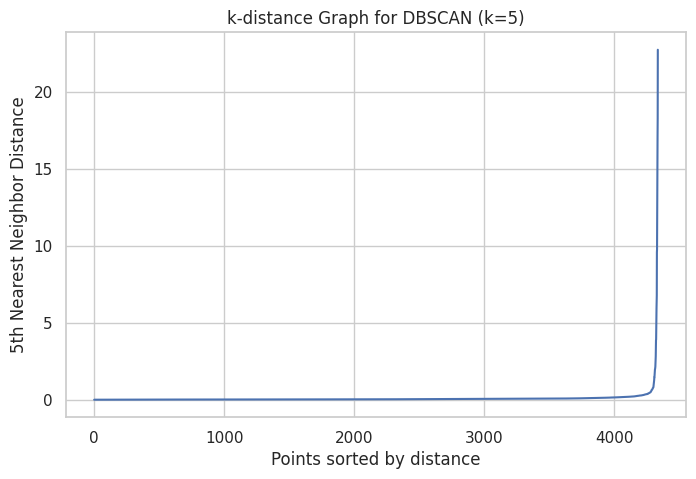

In [12]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

distances = np.sort(distances[:,4])  # 5th nearest neighbor distance
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("k-distance Graph for DBSCAN (k=5)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.show()


DBSCAN k-distance Plot

Description (Markdown above cell):
This plot helps us select the eps parameter for DBSCAN.

DBSCAN groups points that are within eps distance of each other.

To find a good eps, we plot the distance to the k-th nearest neighbor (here k=5).

The "elbow point" (where the curve sharply bends) is the recommended eps.

In [13]:
# PCA reduction to 2D
pca_db = PCA(n_components=2)
db_pca = pca_db.fit_transform(rfm_scaled)
rfm['db_pca1'], rfm['db_pca2'] = db_pca[:,0], db_pca[:,1]

# Scatter plot
fig = px.scatter(rfm, x='db_pca1', y='db_pca2',
                 color='DBSCANCluster',
                 title="DBSCAN Customer Segments",
                 hover_data=['Recency','Frequency','Monetary'])
fig.show()


DBSCAN Visualization (PCA Scatter)

Description (Markdown above cell):
Here, we visualize DBSCAN results in 2D using PCA (Principal Component Analysis).

Each dot = a customer

Colors = DBSCAN cluster assignment

Cluster -1 = Noise (customers not belonging to any cluster)
This shows how DBSCAN separates dense groups and identifies outliers.

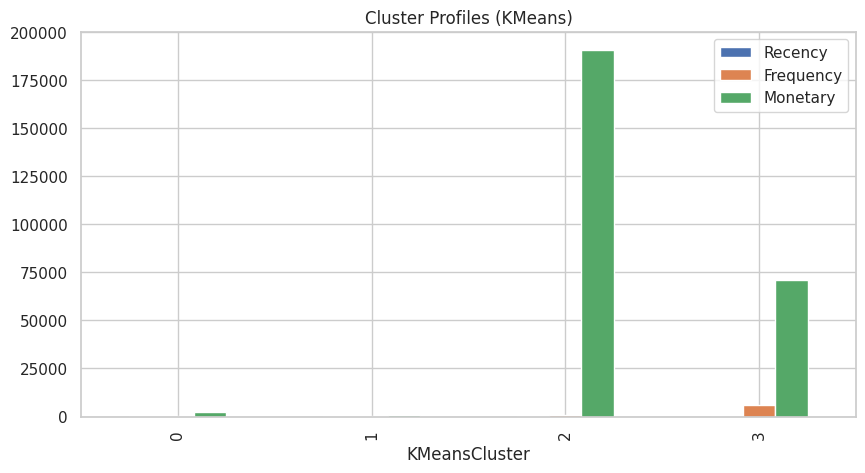

,Recency,Frequency,Monetary
KMeansCluster,,,
0,40.310440,104.605790,2092.276170
1,246.209991,27.789084,637.285163
2,6.666667,826.833333,190863.461667
3,1.000000,5807.000000,70925.287500


In [14]:
# Compare RFM metrics across clusters
cluster_profiles = rfm.groupby('KMeansCluster').mean()[['Recency','Frequency','Monetary']]
cluster_profiles.plot(kind='bar', figsize=(10,5))
plt.title("Cluster Profiles (KMeans)")
plt.show()

cluster_profiles


Cluster Profiling

Description:
Compare RFM metrics across clusters. Helps explain business meaning of each cluster.

In [15]:
# Radar chart for clusters
clusters = cluster_profiles.index
categories = list(cluster_profiles.columns)

fig = go.Figure()
for c in clusters:
    fig.add_trace(go.Scatterpolar(
        r=cluster_profiles.loc[c].values,
        theta=categories,
        fill='toself',
        name=f'Cluster {c}'
    ))

fig.update_layout(title="Customer Cluster Profiles (Radar Chart)", polar=dict(radialaxis=dict(visible=True)))
fig.show()


Interactive Radar Chart

Description:
Radar chart shows each cluster’s profile in Recency, Frequency, Monetary dimensions. Great for presentations

Insights & Recommendations (Markdown)

Description:
We summarize findings in simple business language. Perfect for managers and non-technical viewers.

# Insights & Recommendations

- **Cluster 0 (VIP Customers):** High Monetary, High Frequency, Low Recency → Reward with loyalty programs.
- **Cluster 1 (Occasional Buyers):** Low Frequency, Low Monetary → Engage with discounts/promotions.
- **Cluster 2 (Dormant Customers):** High Recency, very low activity → Reactivation campaigns needed.
- **Cluster 3 (Regular Buyers):** Medium spenders, consistent → Personalize offers to retain.

## Business Value
- Targeted marketing → Higher ROI
- Improved retention → Long-term growth
- Efficient resource allocation

# Thank You!

This concludes the **Week 3 Project – Customer Segmentation**.

### Key Takeaways:
- We segmented customers using **K-Means, Hierarchical Clustering, and DBSCAN**.
- Built **RFM features (Recency, Frequency, Monetary)** for behavior analysis.
- Created interactive and unique **visualizations** for clear interpretation.
- Provided **business insights** that can improve marketing and retention.

### Acknowledgment
I sincerely thank **GNCIPL Internship Program** for providing this opportunity to apply data science techniques to a real-world business problem.  

**Presented by:** *Payal Dhokane*  
**Role:** AIML Intern | Week 3 Project
